In [1]:
import json
from datetime import datetime
import warnings
from copy import deepcopy

import pandas as pd
import numpy as np
import SparseSC
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE

from synth_trainers import calculate_synths, calculate_synths_for_placebo
from vizualization_utils import vizualize_synth, vizualize_post_pre
from calc_utils import calculate_post_pre_mae_relations, try_calculate_p_values, NumpyEncoder

%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

In [2]:
df_grp = pd.read_csv('./datasets/br_grp.csv')
df_industry = pd.read_csv('./datasets/br_industry.csv')
df_export = pd.read_csv('./datasets/br_export.csv')

In [3]:
print(df_grp.isna().sum().sum())
print(df_industry.isna().sum().sum())
print(df_export.isna().sum().sum())

0
0
0


In [4]:
df_export.drop(columns='Unnamed: 0', inplace=True)
df_export.columns = df_export.iloc[0, :].values
df_export.drop(0, inplace=True)
df_export.rename(columns={'Date': 'region'}, inplace=True)

In [5]:
df_grp['region'] = df_grp['region'].str.rstrip().str.lower()
df_industry['region'] = df_industry['region'].str.rstrip().str.lower()
df_export['region'] = df_export['region'].str.rstrip().str.lower()

In [6]:
df_export.drop(columns=[2022, 2023], inplace=True)

In [7]:
sezs_region_and_year = [
    ('ceará', 2010),
    ('piauí', 2010),
    ('acre', 2010),
    ('pernambuco', 2014),
    ('minas gerais', 2018)
]
LIST_OF_REGIONS_WITH_SEZS = [x[0] for x in sezs_region_and_year]

In [8]:
for rname in LIST_OF_REGIONS_WITH_SEZS:
    for df in [df_grp, df_industry, df_export]:
        if rname not in df['region'].tolist():
            print(f'{rname} is not present')
print('finished')

finished


In [9]:
df_grp.index = df_grp['region']
df_grp.drop(columns='region', inplace=True)
df_industry.index = df_industry['region']
df_industry.drop(columns='region', inplace=True)
df_export.index = df_export['region']
df_export.drop(columns='region', inplace=True)

In [10]:
df_grp.head(3)

,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
rondônia,6727.104,155563.620,698670.550,7012856.982,170922.478,1523.780,2959.448,3639.348,4198.007,4611.191,5023.344,5624.964,6082.841,7467.630,9425.010,11004.641,12511.821,13054.713,14438.377,17285.542,19725.010,23907.887,27574.714,30112.720,31121.413,34030.982,36563.333,39460.359,43516.147,44913.978,47091.336,51598.741
acre,1625.935,43990.081,222222.553,2552187.126,55290.490,548.357,995.065,1147.584,1313.635,1453.505,1557.195,1702.621,1920.769,2971.301,3377.234,3784.003,4300.581,4661.807,5458.172,6410.255,7407.821,8342.356,8949.434,10137.925,11473.930,13458.698,13622.802,13754.240,14272.941,15331.123,15630.017,16476.371
amazonas,22329.701,577625.171,2792300.254,27880238.809,733816.175,5878.456,10993.593,14090.343,14410.659,15106.983,15554.778,18872.885,20736.037,22093.338,25862.134,31090.696,33980.877,39933.213,43479.773,48115.265,50559.840,60877.123,70734.401,72242.701,83051.233,86668.644,86568.184,89039.782,93240.191,100109.235,108181.091,116019.139


In [11]:
df_industry.head(3)

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
region,,,,,,,,,,,,,,,,,,,
rondônia,1926,1947,2567,3130,3050,1172,5297,5405,1243,8678,10019,12730,5493,15589,16954,21145,10533,21469,23514
acre,209,299,341,439,480,695,907,935,978,1045,1245,1529,1637,1919,2231,2231,2170,2063,2262
amazonas,29198,38416,47850,53484,58985,55328,64023,59282,12752,80804,79881,96682,12964,95783,89306,101378,115877,128842,136950


In [12]:
df_export.head(3)

,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
pernambuco,322975.000,400464.000,336729.000,352431.000,345650.000,372739.000,574321.000,341005.000,372580.000,362258.000,265876.000,283805.000,334551.000,319768.000,410550.000,516590.000,783865.000,780075.000,868780.000,934797.000,815217.000,1108213.000,1195849.000,1317599.000,834606.000,941117.000,1046329.000,1416831.000,1961395.000,1995432.000,1466346.000,1578870.000,2112290.000
paraíba,66157.000,52551.000,56076.000,59083.000,69969.000,83646.000,86066.000,103393.000,86940.000,54083.000,62683.000,77576.000,105144.000,117623.000,168248.000,213892.000,227721.000,208590.000,235353.000,226859.000,156589.000,216910.000,224608.000,243087.000,187635.000,179080.000,141364.000,121467.000,140722.000,115553.000,126301.000,125272.000,146643.000
alagoas,152533.000,291399.000,272268.000,243461.000,237810.000,240949.000,468142.000,289194.000,340729.000,291754.000,224946.000,224353.000,304408.000,298644.000,360909.000,457656.000,583777.000,692543.000,663662.000,876554.000,823949.000,970595.000,1371187.000,1014102.000,741918.000,629145.000,672249.000,420860.000,665015.000,502094.000,319090.000,418185.000,444680.000


In [13]:
df_grp.columns = df_grp.columns.astype(int)
df_industry.columns = df_industry.columns.astype(int)
df_export.columns = df_export.columns.astype(int)

In [14]:
DATAFRAMES = {
    'grp': df_grp, 
    'industry': df_industry, 
    'export': df_export, 
}

In [15]:
synths_for_each_region = {}
for current_region, current_year in sezs_region_and_year:
    print(f"Calculating for {current_region}")
    synths_for_each_region[current_region] = calculate_synths(current_region, current_year, LIST_OF_REGIONS_WITH_SEZS, DATAFRAMES)

Calculating for ceará
		 Calculating for grp
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>>>>| 
		 Calculating for industry
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>| 
		 Calculating for export
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>>>>| 
Calculating for piauí
		 Calculating for grp
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>>>>>| 
		 Calculating for industry
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the 

variables to choose: grp, industry, export


regions to choose: ('ceará', 2010), ('piauí', 2010), ('acre', 2010), ('pernambuco', 2014), ('minas gerais', 2018)

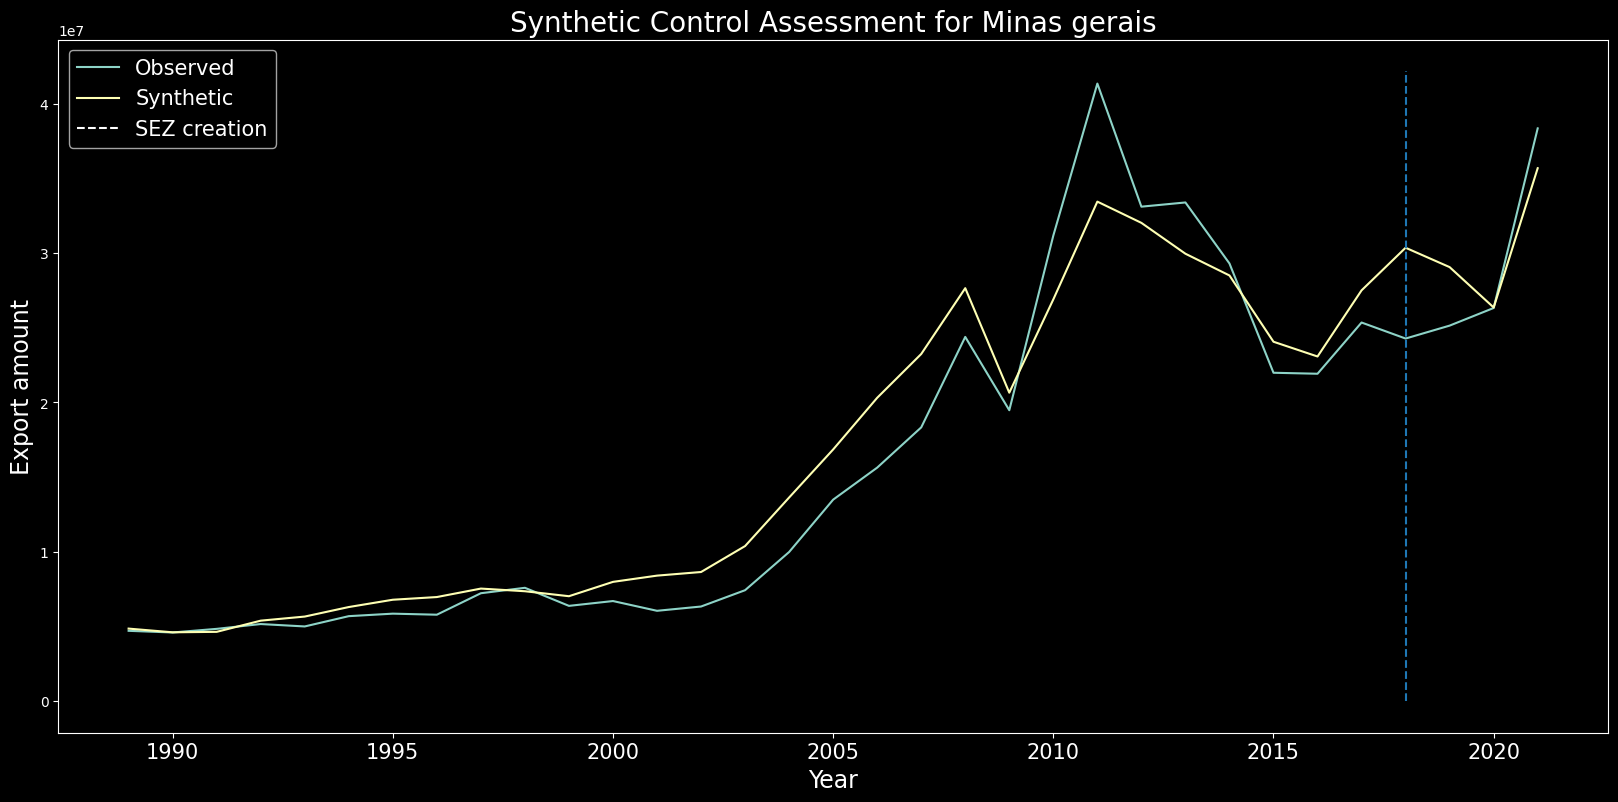

In [16]:
df = synths_for_each_region['minas gerais']['export']['res_df']
reigon_annotation = 'Minas gerais'
variable_annotation = 'Export amount'
treatment_year = synths_for_each_region['minas gerais']['treatment_year']
vizualize_synth(df, reigon_annotation, variable_annotation, treatment_year)

('ceará', 2010), ('piauí', 2010), ('acre', 2010), ('pernambuco', 2014), ('minas gerais', 2018)

In [17]:
df = synths_for_each_region['ceará']['export']['res_df']
treatment_year = 2010
mae_pre = MAE(df[df['year'] <= treatment_year]['Observed'].values, df[df['year'] <= treatment_year]['Synthetic'].values)
mae_post = MAE(df[df['year'] > treatment_year]['Observed'].values, df[df['year'] > treatment_year]['Synthetic'].values)
pd.DataFrame({
    'Pre': [mae_pre],
    'Post': [mae_post],
    'Post/Pre': [mae_post/mae_pre]
}, index=['MAE'])

,Pre,Post,Post/Pre
MAE,37122.478,416864.980,11.229


In [21]:
synths_for_placebo = {}
for i in range(4):
    current_region = df_grp.index.values[np.random.randint(0, len(df_grp))]
    current_year = 2011
    
    while current_region in LIST_OF_REGIONS_WITH_SEZS:
        current_region = df_grp.index.values[np.random.randint(0, len(df_grp))]


    print(f"Calculating for {current_region}")
    synths_for_placebo[current_region] = calculate_synths_for_placebo(current_region, current_year, LIST_OF_REGIONS_WITH_SEZS, DATAFRAMES)

Calculating for paraná
Calculating for paraíba
Calculating for rio grande do norte
Calculating for pará


In [22]:
post_pre_relations = calculate_post_pre_mae_relations(synths_for_placebo, synths_for_each_region, sezs_region_and_year)

In [23]:
colors = ['cyan' for _ in range(len(post_pre_relations['grp']['x']) - len(list(synths_for_placebo.keys())))]
colors.extend(['green'] * len(list(synths_for_placebo.keys())))

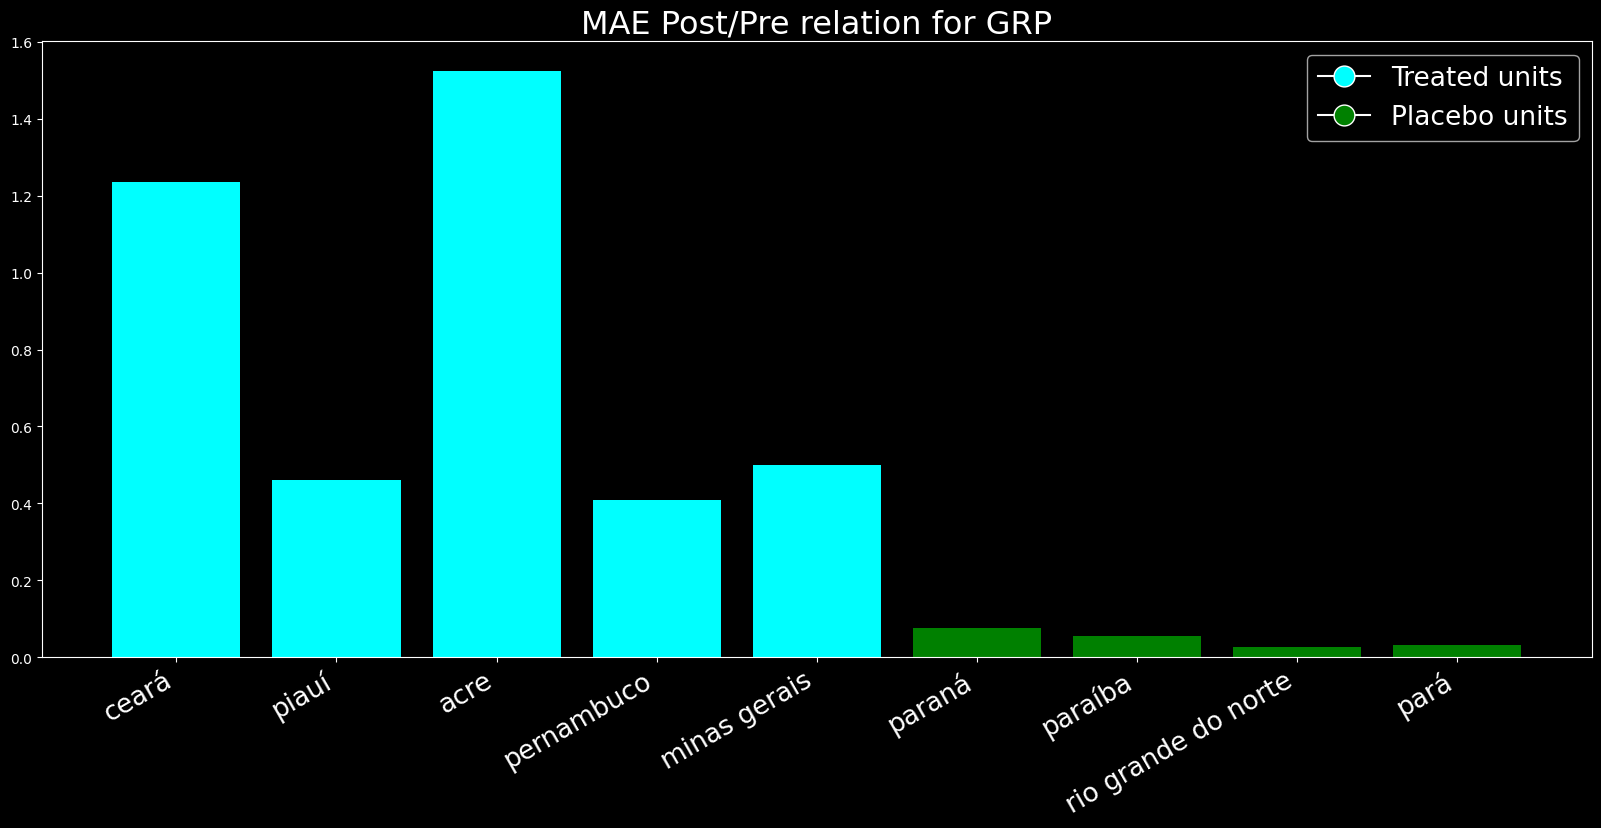

In [24]:
variable_dict = post_pre_relations['grp']
variable_name = 'GRP'
vizualize_post_pre(variable_dict, variable_name, colors)

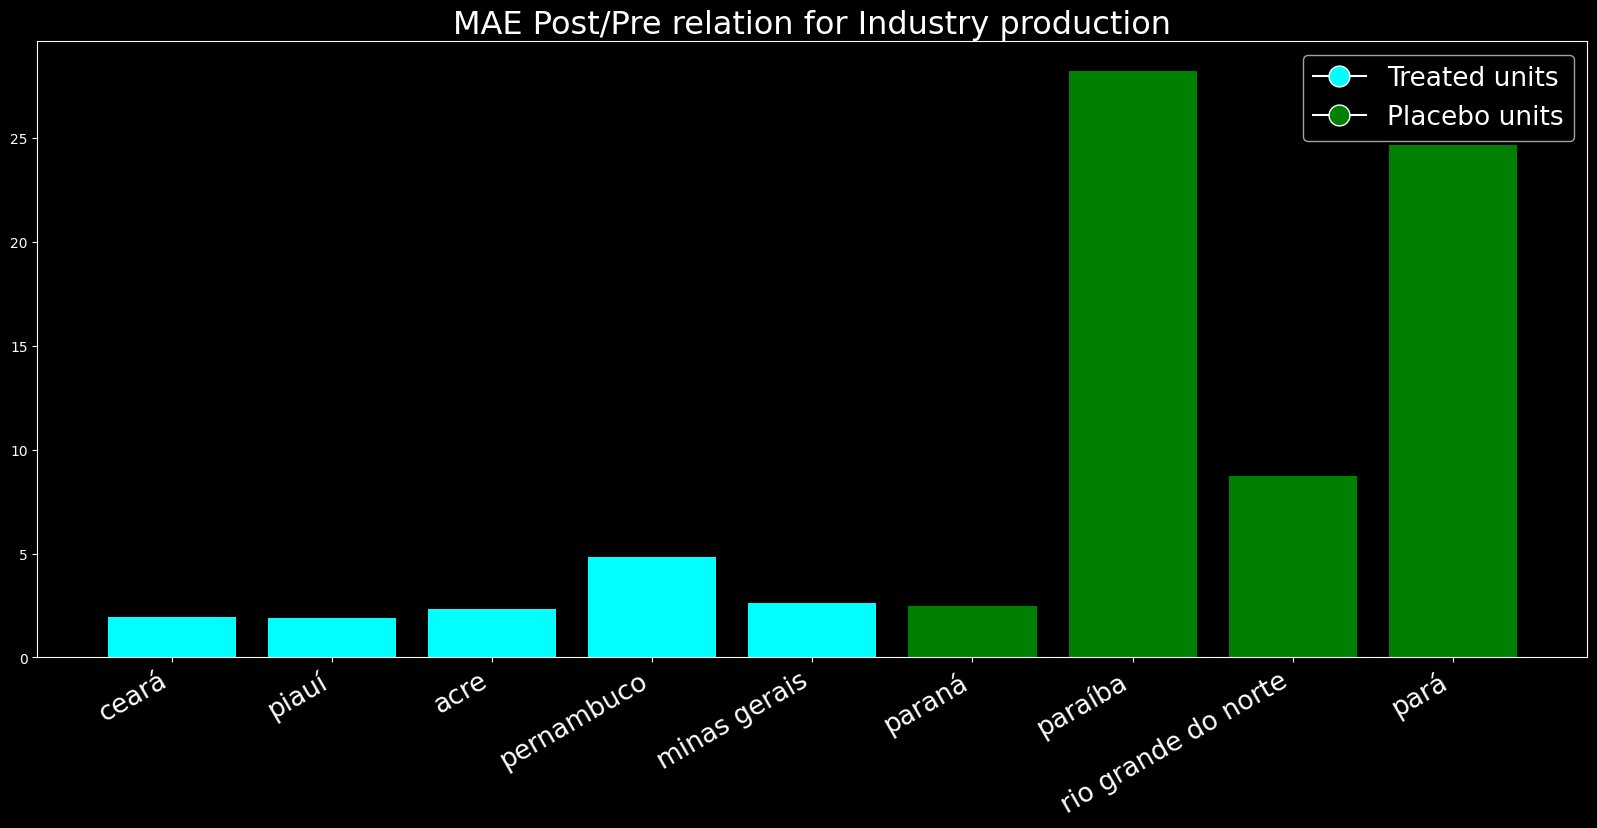

In [25]:
variable_dict = post_pre_relations['industry']
variable_name = 'Industry production'
vizualize_post_pre(variable_dict, variable_name, colors)

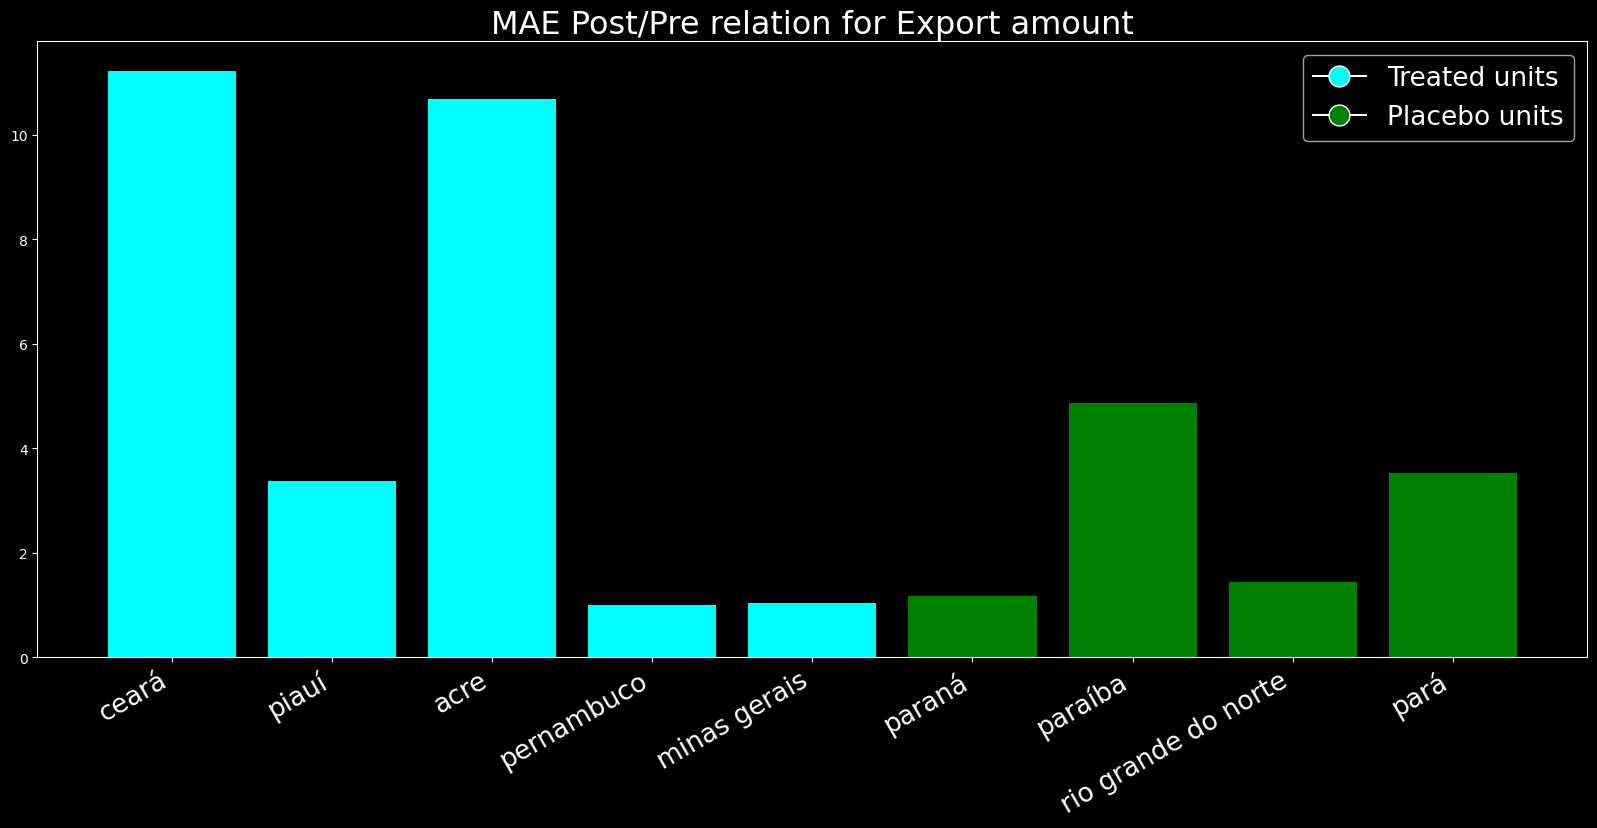

In [26]:
variable_dict = post_pre_relations['export']
variable_name = 'Export amount'
vizualize_post_pre(variable_dict, variable_name, colors)

In [28]:
filename = 'p_for_brazil.txt'
try_calculate_p_values(filename, sezs_region_and_year, synths_for_each_region, DATAFRAMES)

Calculating for ('ceará', 2010)
Unique weights not possible.
Matrix is singular. occured for ceará, grp
Unique weights not possible.
Matrix is singular. occured for ceará, export
Calculating for ('piauí', 2010)
Unique weights not possible.
Matrix is singular. occured for piauí, grp
Calculating for ('acre', 2010)
Unique weights not possible.
Matrix is singular. occured for acre, grp
Calculating for ('pernambuco', 2014)
Unique weights not possible.
Matrix is singular. occured for pernambuco, export
Calculating for ('minas gerais', 2018)
Unique weights not possible.
Matrix is singular. occured for minas gerais, grp
Unique weights not possible.
Matrix is singular. occured for minas gerais, export


In [32]:
result = {'treated': deepcopy(synths_for_each_region), 'placebo': deepcopy(synths_for_placebo)}

In [33]:
for synth_group in result.keys():
    for rname in result[synth_group].keys():
        for variable in result[synth_group][rname].keys():
            if variable != 'treatment_year':
                result[synth_group][rname][variable]['synth'] = {
                    'weights': result[synth_group][rname][variable]['synth'].get_weights(True),
                    'v_matrix': result[synth_group][rname][variable]['synth'].V,
                    'v_pen': result[synth_group][rname][variable]['synth'].fitted_v_pen,
                    'w_pen': result[synth_group][rname][variable]['synth'].fitted_w_pen
                }
                result[synth_group][rname][variable]['res_df'] = result[synth_group][rname][variable]['res_df'].to_dict()

In [34]:
with open("./results/result_brazil.json", "w") as outfile:
    json.dump(result, outfile, indent=4, cls=NumpyEncoder)